## Outline
- [Part 1:  import packages](#0)
    - 1.1  deal with data packages
    - 1.2  preprocessing images packages
    - 1.3  model building packages
    - 1.4  data visualization packages  
    - 1.5  evaluate the model packages  
    
- [Part 2:  prepare the data](#1)
    - [2.1  sample of the preprocessing](#1.1)
    
- [Part 3:  the model](#2)
    - [3.1  build the model](#2.1)
    - [3.2  train the model](#2.2)
    - [3.3  train & validation loss and accuracy per epochs](#2.3)

- [Part 4:  Testing and evaluation](#4)
    - [4.1  model evaluation](#4.1)
    - [4.2  confusion matrix](#4.2)
    - [4.3  classification_report](#4.3)


<a name="0"></a>
## import packages 

In [33]:
import glob
import pandas as pd
import numpy as np
import pickle
from tqdm import tqdm

#for images preprocessing
from sklearn.model_selection import train_test_split
import cv2
from skimage.feature import hog,canny
from skimage.color import rgb2gray

#for model
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Conv2D, BatchNormalization, MaxPool2D, Dropout, Flatten, Dense

#for model evaluation and visualization
from sklearn.metrics import confusion_matrix
import seaborn as sn
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# to avoid gpu errors
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

<a name="1"></a>

## prepare the data

In [3]:
train_path='C:/Users/mmmmm/jupyter projects/selected2/dataset_new/train'

In [82]:
# prepare x data
open_eyes= glob.glob(train_path+'/Open/*.jpg')
closed_eyes= glob.glob(train_path+'/Closed/*.jpg')
len(open_eyes),len(closed_eyes)

(626, 626)

In [68]:
# prepare labels
open_labels=np.ones(len(open_eyes),dtype=int)
closed_labels=np.zeros(len(closed_eyes),dtype=int)
y= np.concatenate((open_labels,closed_labels))
x.shape,y.shape

((1252,), (1252,))

<a name="1.1"></a>

## sample of the preprocessing

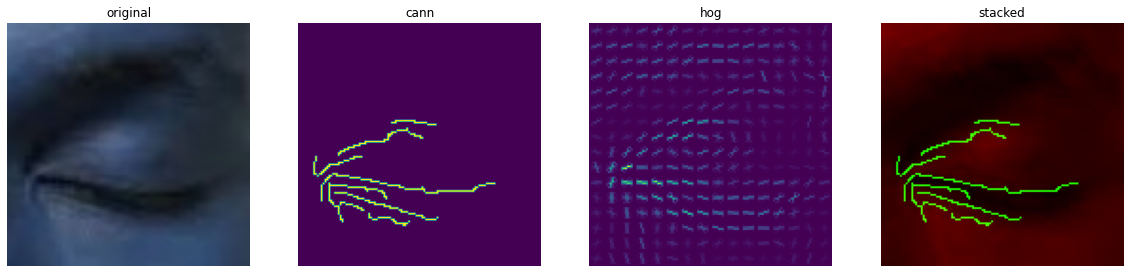

In [29]:
gray =rgb2gray(X_test[40])

fd, hog_image = hog(gray, orientations=8,cells_per_block=(1, 1), visualize=True)

cann = canny(gray, sigma=1) 

stacked = np.dstack((gray,cann,hog_image))

imgs=[X_test[40],cann,hog_image,stacked]
titles=['original','cann','hog','stacked']

fig, ax = plt.subplots(nrows = 1, ncols = 4, figsize = (20,20))

for i in range(0,4):
    ax[i].imshow(imgs[i])
    ax[i].set_title(titles[i])
    ax[i].axis('off')
    imgs[i].shape
# plt.imshow(imgs[1])


In [30]:
def preprocess(img):
    
    gray =rgb2gray(cv2.resize(img,(128,128)))

    fd, hog_image = hog(gray, orientations=8,cells_per_block=(1, 1), visualize=True)
    cann = canny(gray, sigma=1) 

    stacked = np.dstack((gray,cann,hog_image))
    
    return stacked

In [34]:
# apply the preprocess on all the data
preprocessed_x=[]
for i in tqdm(range(0,len(x))):
    img=plt.imread(x[i])
    preprocessed_x.append(preprocess(img))
    
preprocessed_x=np.array(preprocessed_x)
y=np.array(y)

 61%|████████████████████████████████████████████████▍                              | 767/1252 [00:35<00:23, 20.66it/s]<ipython-input-30-646b5645aa9c>:3: FutureWarning: Non RGB image conversion is now deprecated. For RGBA images, please use rgb2gray(rgba2rgb(rgb)) instead. In version 0.19, a ValueError will be raised if input image last dimension length is not 3.
  gray =rgb2gray(cv2.resize(img,(128,128)))
100%|██████████████████████████████████████████████████████████████████████████████| 1252/1252 [00:57<00:00, 21.74it/s]


In [69]:
# split data to train and validation data
X_train, X_val, y_train, y_val= train_test_split(preprocessed_x,y,test_size=0.2)

<a name="2"></a>
<a name="2.1"></a>

## build the CNN model

In [70]:
model = Sequential()

# Input layer
model.add(InputLayer(input_shape = (128,128,3)))


# Adding layers
model.add(Conv2D(filters = 32,   kernel_size  = (3, 3), padding='valid', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (2, 2), padding = 'valid'))
model.add(Dropout(0.3))

model.add(Conv2D(filters = 64,   kernel_size  = (3, 3), padding='valid', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (2, 2), padding = 'valid'))
model.add(Dropout(0.4))

model.add(Conv2D(filters = 128,  kernel_size  = (3, 3), padding='valid', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (2, 2), padding = 'valid'))
model.add(Dropout(0.4))

# model.add(Conv2D(filters = 256,  kernel_size  = (3, 3), padding='valid', activation='relu'))
# model.add(BatchNormalization())
# model.add(MaxPool2D(pool_size = (2, 2), padding = 'valid'))
# model.add(Dropout(0.4))
# Adding flatten
model.add(Flatten())


# Adding full connected layer (dense)
model.add(Dense(units = 512, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

# model.add(Dense(units = 256, activation = 'relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.4))


# Adding output layer
model.add(Dense(units = 1, activation='sigmoid'))

model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 batch_normalization_8 (Batc  (None, 126, 126, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 63, 63, 32)       0         
 2D)                                                             
                                                                 
 dropout_8 (Dropout)         (None, 63, 63, 32)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_9 (Batc  (None, 61, 61, 64)      

<a name="2.2"></a>

## train the model

In [71]:
model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'binary_crossentropy', metrics = ['accuracy'])
history= model.fit(X_train,y_train ,validation_data=(X_val,y_val) ,epochs=30)

Epoch 1/30
32/32 [==============================] - 7s 173ms/step - loss: 0.5535 - accuracy: 0.8252 - val_loss: 0.8457 - val_accuracy: 0.5339
Epoch 2/30
32/32 [==============================] - 5s 168ms/step - loss: 0.2435 - accuracy: 0.9081 - val_loss: 0.9026 - val_accuracy: 0.4502
Epoch 3/30
32/32 [==============================] - 5s 168ms/step - loss: 0.1612 - accuracy: 0.9331 - val_loss: 3.8497 - val_accuracy: 0.4701
Epoch 4/30
32/32 [==============================] - 5s 168ms/step - loss: 0.1521 - accuracy: 0.9421 - val_loss: 3.8845 - val_accuracy: 0.4701
Epoch 5/30
32/32 [==============================] - 5s 168ms/step - loss: 0.1463 - accuracy: 0.9421 - val_loss: 5.7363 - val_accuracy: 0.4701
Epoch 6/30
32/32 [==============================] - 5s 168ms/step - loss: 0.0860 - accuracy: 0.9680 - val_loss: 4.5864 - val_accuracy: 0.4701
Epoch 7/30
32/32 [==============================] - 5s 168ms/step - loss: 0.0553 - accuracy: 0.9790 - val_loss: 5.0246 - val_accuracy: 0.4701
Epoch 

<a name="2.3"></a>

## train & validation [loss,accuracy] per epoch the model

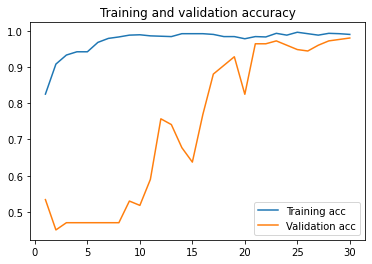

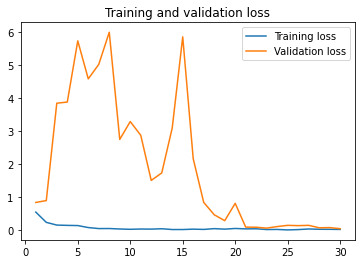

In [72]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']


import matplotlib.pyplot as plt

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

<a name="4"></a>

## test & evaluate the model

In [21]:
X_test = pickle.load(open('test_images.pkl', 'rb'))
y_test = pickle.load(open('test_labels.pkl', 'rb'))

In [75]:
def pred(model,data):
    imgs= []
    for i in data:
        imgs.append(preprocess(i))
    imgs = np.array(imgs)
    print(imgs.shape)    
    return model.predict(imgs)

def evalu(model,data,labels):
    imgs= []
    for i in data:
        imgs.append(preprocess(i))
    imgs = np.array(imgs)
    print(imgs.shape)
    return model.evaluate(imgs,labels)

<a name="4.1"></a>

## model evaluation

In [73]:
evalu(model,X_test,y_test)

(200, 128, 128, 3)
7/7 [==============================] - 0s 50ms/step - loss: 0.0349 - accuracy: 0.9800


[0.03494064509868622, 0.9800000190734863]

In [76]:
pred = pred(model,X_test)
pred=np.around(pred,decimals=1)
pred[0:10]

(200, 128, 128, 3)


array([[0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.]], dtype=float32)

In [65]:
y_test[0:10]

array([0, 0, 1, 0, 0, 0, 0, 0, 1, 0])

<a name="4.2"></a>

## confusion matrix

<AxesSubplot:>

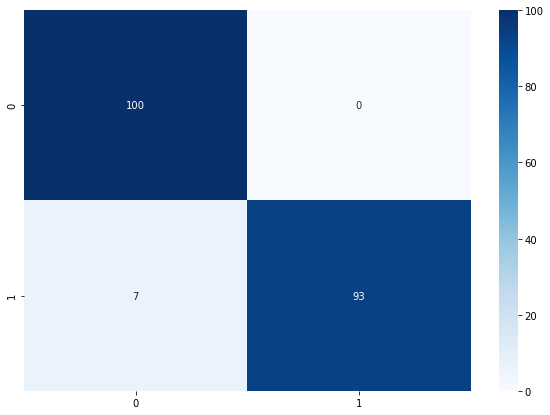

In [80]:


cf_matrix = confusion_matrix(y_test, pred.astype(int))


plt.figure(figsize = (10,7))
sn.heatmap(cf_matrix, annot=True,cmap='Blues', fmt='g')

<a name="4.3"></a>

## classification report

In [81]:
target_names = ['close', 'open']
print(classification_report(y_test,  pred.astype(int),target_names=target_names))

              precision    recall  f1-score   support

       close       0.93      1.00      0.97       100
        open       1.00      0.93      0.96       100

    accuracy                           0.96       200
   macro avg       0.97      0.97      0.96       200
weighted avg       0.97      0.96      0.96       200



In [83]:
model.save('slected_model_v2')

INFO:tensorflow:Assets written to: slected_model_v2\assets
